# Torchhd
reference: https://torchhd.readthedocs.io/en/stable/getting_started.html

## 数据结构与操作
以不同的方式创建超维张量表示
| Recor              | Ruit          | Weight          |  Season          |
| --------------- | ----------- | ----------- | ----------- |
| r1| apple         | 149.0 | fall|
| r2| lemon  | 70.5 | winter |
| r3| mango | 173.2 | summer |


In [2]:
import torchhd

d = 10000 # dimensions
fruits = torchhd.random(3, d)
weights = torchhd.level(10, d)
seasons = torchhd.circular(4, d)
var = torchhd.random(3, d)
fruits.shape, fruits

(torch.Size([3, 10000]),
 MAPTensor([[ 1., -1., -1.,  ..., -1.,  1., -1.],
            [ 1., -1.,  1.,  ..., -1.,  1., -1.],
            [ 1., -1.,  1.,  ..., -1.,  1.,  1.]]))

然后可以索引其中的部分元素

In [ ]:
import torch

weight = torch.tensor([149.0])
# explicit mapping of the fruit weight to an index
w_i = torchhd.value_to_index(weight, 0, 200, 10) 
weights[w_i]  # select representation of 149

MAPTensor([[-1., -1.,  1.,  ..., -1.,  1., -1.]])

通过内置的模块

In [5]:
from torchhd import embeddings

W_emb = embeddings.Level(10, d, low=0, high=200)
# select representation of 149
W_emb(weight)  # same result as weights[w_i]

MAPTensor([[ 1.,  1.,  1.,  ..., -1., -1., -1.]])

## 操作
以 MAP 操作为例，通过 bind bundle 操作创建关联

In [8]:
f = torchhd.bind(var[0], fruits[0])   # fruit = apple
w = torchhd.bind(var[1], weights[w_i]) # weight = 149
s = torchhd.bind(var[2], seasons[3])   # season = fall
r1 = torchhd.bundle(torchhd.bundle(f, w), s)
r1_prime = var[0] * fruits[0] + var[1] * weights[w_i] + var[2] * seasons[3]
r1, r1 == r1_prime

(MAPTensor([[-1.,  1.,  1.,  ..., -1., -1., -1.]]),
 MAPTensor([[True, True, True,  ..., True, True, True]]))

或者运用其他数据结构，如 hashtable

In [18]:
# combine values in one tensor of shape (3, d)
# weights shape is [1, d]
values = torch.stack([fruits[0], weights[w_i][0], seasons[3]])
r1 = torchhd.hash_table(var, values)
r1
# fruits[0].shape, weights[w_i][0]

MAPTensor([-1.,  1.,  1.,  ..., -1., -1., -1.])

In [11]:
from torchhd import structures

r1 = structures.HashTable(d)  # r1 = 0
r1.add(var[0], fruits[0])     # r1 + var[0] * fruits[0]
r1.add(var[1], weights[w_i])   # r1 + var[1] * weights[w_i]
r1.add(var[2], seasons[3])     # r1 + var[2] * seasons[3]
# query the hash table by key:
fruit = r1.get(var[0])   # r1 * var[0]
weight = r1.get(var[1])  # r1 * var[1]
season = r1.get(var[2])  # r1 * var[2]

# HDC learning

Using MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

import torchhd
from torchhd.models import Centroid
from torchhd import embeddings


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

DIMENSIONS = 10000
IMG_SIZE = 28
NUM_LEVELS = 1000
BATCH_SIZE = 1  # for GPUs with enough memory we can process multiple images at ones

Using cuda device


定义了一个转换函数，将MNIST数据集中的图像转换为张量。

然后加载MNIST训练数据集和测试数据集，并创建相应的数据加载器（DataLoader）。

In [2]:
transform = torchvision.transforms.ToTensor()

train_ds = MNIST("../data", train=True, transform=transform, download=True)
train_ld = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = MNIST("../data", train=False, transform=transform, download=True)
test_ld = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## training
To perform the training, we start by defining an encoding. In addition to specifying the basis-hypervectors sets, a core part of learning is the encoding function. In the example below, we use **random-hypervectors and level-hypervectors to encode the position and value of each pixel**, respectively:

定义了一个编码器（Encoder）类，它继承自nn.Module。编码器包括一个flatten层，一个随机位置编码层（position），和一个基于级别的值编码层（value）。编码器的前向传播方法（forward）将输入的图像张量转换为硬量化的向量。

然后，创建编码器实例并将其移动到设定的设备上。确定类别数量，并创建Centroid模型实例，也将其移动到设定的设备上。

In [3]:
class Encoder(nn.Module):
    def __init__(self, out_features, size, levels):
        super(Encoder, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.position = embeddings.Random(size * size, out_features)
        self.value = embeddings.Level(levels, out_features)

    def forward(self, x):
        x = self.flatten(x)
        sample_hv = torchhd.bind(self.position.weight, self.value(x))
        sample_hv = torchhd.multiset(sample_hv)
        return torchhd.hard_quantize(sample_hv)


encode = Encoder(DIMENSIONS, IMG_SIZE, NUM_LEVELS)
encode = encode.to(device)

num_classes = len(train_ds.classes)
model = Centroid(DIMENSIONS, num_classes)
model = model.to(device)

在不需要计算梯度的情况下，遍历训练数据集，使用编码器将图像转换为硬量化向量，并使用模型的add方法将它们添加到聚类中心。

Having defined the model, we iterate over the training samples to create the class-vectors:

In [26]:
with torch.no_grad():
    for samples, labels in tqdm(train_ld, desc="Training"):
        samples = samples.to(device)
        labels = labels.to(device)

        samples_hv = encode(samples)
        model.add(samples_hv, labels)

Training:   0%|                                                                                                                                                                   | 0/60000 [00:00<?, ?it/s]/tmp/ipykernel_20549/1987552506.py:12: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [01:30<00:00, 666.33it/s]


初始化一个Accuracy指标，用于计算模型的准确率。
在不需要计算梯度的情况下，对测试数据集进行评估。模型被归一化，然后使用编码器将测试图像转换为硬量化向量，并通过模型获取输出。然后更新Accuracy指标。

In [27]:
accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)

with torch.no_grad():
    model.normalize()

    for samples, labels in tqdm(test_ld, desc="Testing"):
        samples = samples.to(device)

        samples_hv = encode(samples)
        outputs = model(samples_hv, dot=True)
        accuracy.update(outputs.cpu(), labels)

print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")

Testing:   0%|                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_20549/1987552506.py:12: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 521.92it/s]

Testing accuracy of 82.770%


## 编程指导

## 数据处理
ToTensor()的工作原理如下：

1. 将图像的像素值从整数类型[0, 255]归一化到浮点数类型[0.0, 1.0]。这是通过将每个像素值除以255来实现的。

2. 将图像数据的形状从(H x W x C)转换为(C x H x W)。对于彩色图像，这意味着将图像从高度、宽度、通道的格式转换为通道、高度、宽度的格式。这种格式是PyTorch张量的标准格式。

3. 如果输入是PIL图像，它还会将图像模式从'L'（灰度）、'RGB'或'RGBA'转换为相应的张量格式。

1. `train_ds`：这个变量是 `MNIST` 数据集的一个实例，它包含了MNIST手写数字数据集的训练集。`MNIST` 类是 `torchvision.datasets` 模块中的一个类，它继承自 `torch.utils.data.Dataset`。因此，`train_ds` 是一个 `Dataset` 对象，它提供了访问和处理MNIST训练数据的方法。

2. `train_ld`：这个变量是 `DataLoader` 对象，它是一个迭代器，用于在训练过程中批量加载数据。`DataLoader` 类是 `torch.utils.data` 模块中的一个类，它封装了 `Dataset` 对象，并提供了额外的功能，如自动批量处理、打乱数据顺序（如果 `shuffle=True`）、多进程数据加载等。因此，`train_ld` 是一个 `DataLoader` 对象，它可以用来在训练循环中迭代获取数据。

具体来说：

- `MNIST` 类的实例化过程中，`train=True` 参数指定了要加载训练集，`transform=transform` 应用了之前定义的 `ToTensor` 转换，将图像转换为张量，`download=True` 表示如果本地没有数据集则需要下载数据集。
- `DataLoader` 类的实例化过程中，`train_ds` 是被封装的 `Dataset` 对象，`batch_size=BATCH_SIZE` 指定了每个批次的样本数量，`shuffle=True` 表示在每个epoch开始时将数据集打乱。

在实际使用中，`train_ld` 通常在训练循环中使用，例如：

```python
for data, target in train_ld:
    # 训练模型的代码
    pass
```

每次迭代时，`train_ld` 会从 `train_ds` 中自动取出一个批次的数据和标签，然后你可以用这些数据来训练你的模型。

## 定义算法

torchhd.multiset(sample_hv) 将结合后的编码转换为多集（multiset）表示，这是一种数据结构，用于表示具有重复元素的集合。
torchhd.hard_quantize(sample_hv) 对多集表示进行硬量化，将其转换为离散的直方图向量。

Centroid 是一个聚类模型，它使用直方图向量作为特征。这里是torchhd 自己实现的 model。

In [28]:
model

Centroid(in_features=10000, out_features=10)

# 图形化 向量间的距离关系

In [41]:
import torchhd

d = 10000 # dimensions
num = 20
rand_iM = torchhd.random(num, d)
level_iM = torchhd.level(num, d)
circ_iM = torchhd.circular(num, d)

rel_rand = torchhd.cosine_similarity(rand_iM, rand_iM)
lev_rand = torchhd.cosine_similarity(level_iM, level_iM)
cir_rand = torchhd.cosine_similarity(circ_iM, circ_iM)


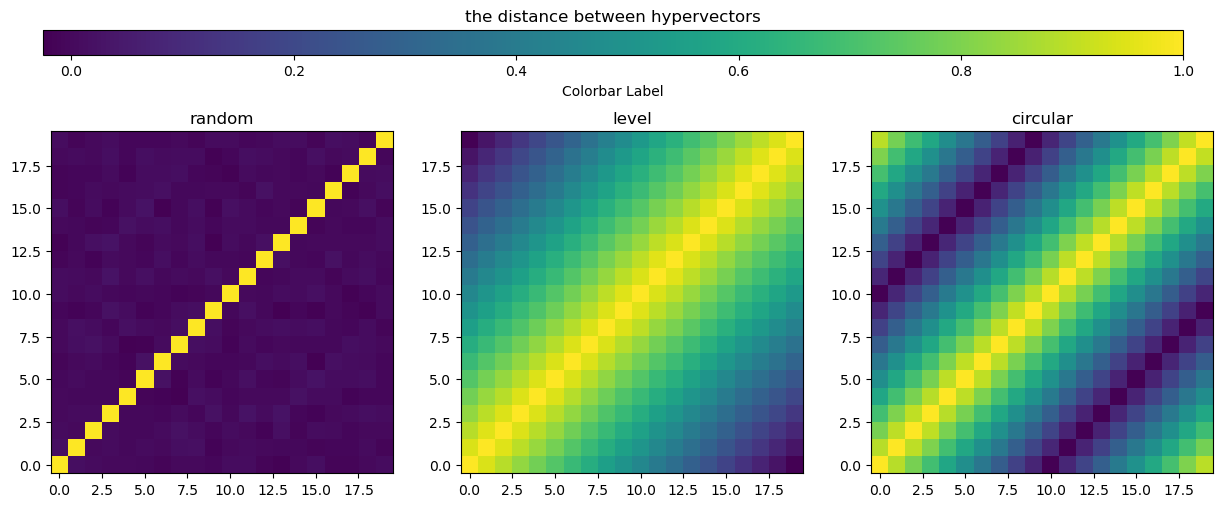

In [51]:
import matplotlib.pyplot as plt
# plt.xticks(np.arange(len(farmers)), labels=farmers, 
#                      rotation=45, rotation_mode="anchor", ha="right")
# plt.yticks(np.arange(len(vegetables)), labels=vegetables)

# for i in range(len(vegetables)):
#     for j in range(len(farmers)):
#         text = plt.text(j, i, harvest[i, j], ha="center", va="center", color="w")

# 创建一个图形窗口
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

# 绘制第一个热力图
cax1 = axs[0].imshow(rel_rand, origin = 'lower', cmap = 'viridis')  # 'hot'是颜色映射，可以根据需要选择其他颜色映射
axs[0].set_title('random')

# 绘制第二个热力图
cax2 = axs[1].imshow(lev_rand, origin = 'lower', cmap = 'viridis')
axs[1].set_title('level')

# 绘制第三个热力图
cax3 = axs[2].imshow(cir_rand, origin = 'lower', cmap = 'viridis')
axs[2].set_title('circular')

# 创建一个空的子图用于颜色条
cax = fig.add_axes([0.12, 0.95, 0.76, 0.05])  # [left, bottom, width, height]
# 添加颜色条
cbar = fig.colorbar(cax1, cax = cax, orientation='horizontal')

# 设置颜色条的位置
cbar.set_label('Colorbar Label')

# 调整子图之间的间距，为颜色条腾出空间
plt.subplots_adjust(top = 0.8)
plt.title("the distance between hypervectors")
plt.show()